✅ Dataset loaded successfully!
🔍 Unique ATC codes in dataset: ['medA' 'medB']
✅ Processing ATC Code: medA


C:\Users\rapha\AppData\Local\Temp\ipykernel_4632\3806020329.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  C09CA01 = C09CA01.groupby("pnr", group_keys=False).apply(lambda x: x.sample(1))


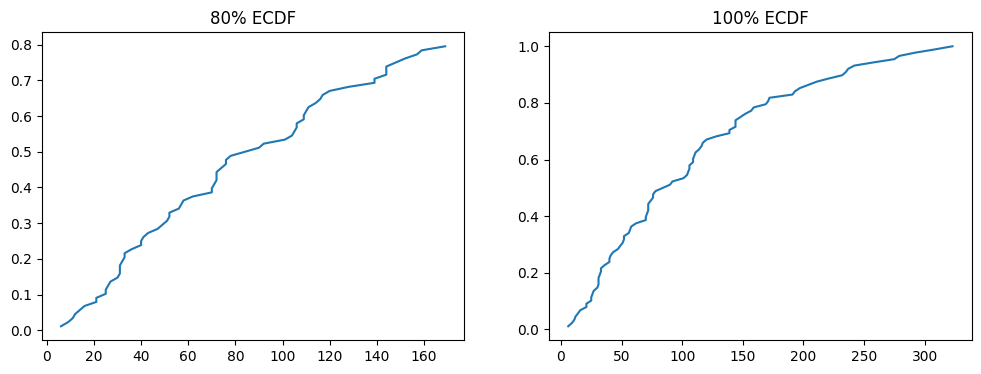

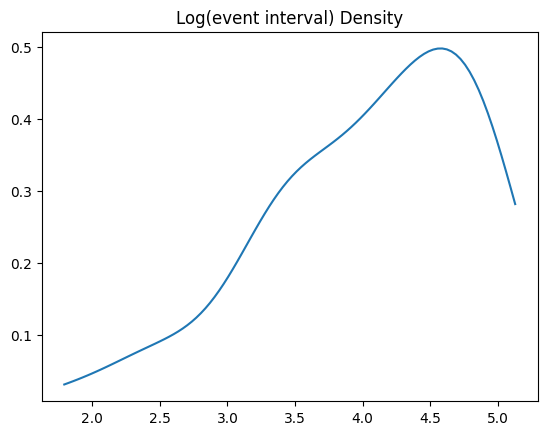

✅ Processing ATC Code: medB


C:\Users\rapha\AppData\Local\Temp\ipykernel_4632\3806020329.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  C09CA01 = C09CA01.groupby("pnr", group_keys=False).apply(lambda x: x.sample(1))


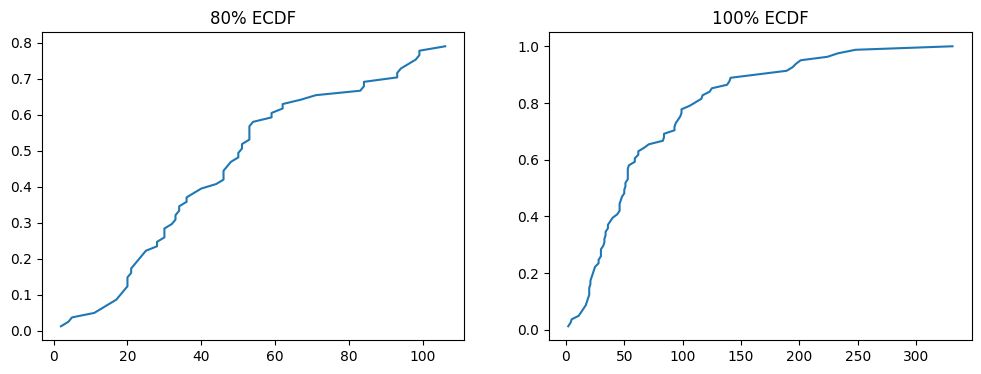

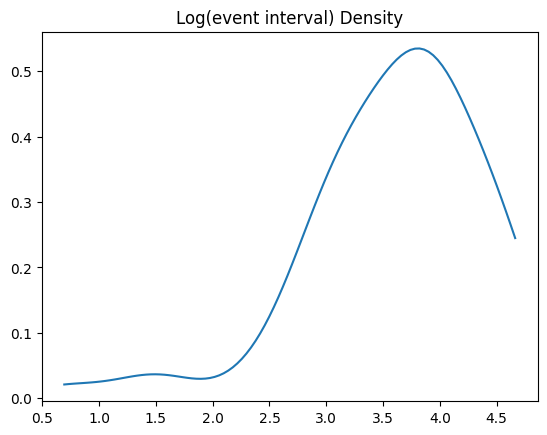

medA shape: (0, 4) medA columns: Index(['pnr', 'eksd', 'median', 'cluster'], dtype='object')
medB shape: (78, 4) medB columns: Index(['pnr', 'eksd', 'median', 'cluster'], dtype='object')
⚠️ Warning: One or both datasets (medA, medB) are empty.


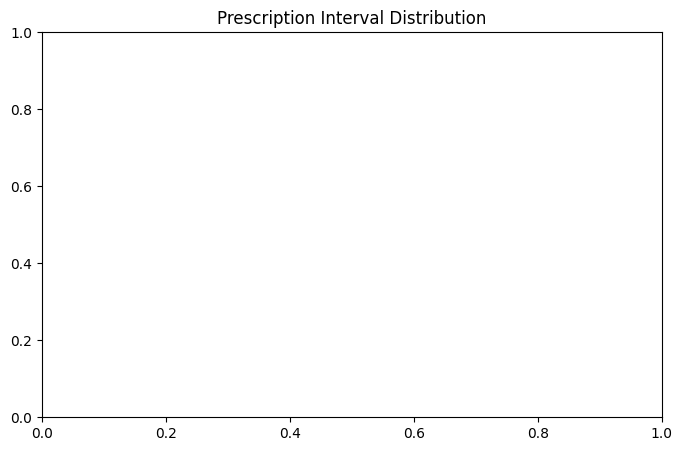

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load dataset
try:
    med_events = pd.read_csv("../data/med_events.csv")  # Adjust path if necessary
    print("✅ Dataset loaded successfully!")
except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    med_events = None

# Ensure dataset is not empty
if med_events is None or med_events.empty:
    print("❌ Error: Dataset is empty or not loaded correctly.")
else:
    med_events.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]
    med_events["eksd"] = pd.to_datetime(med_events["eksd"])

    # Debugging: Check unique ATC codes
    print("🔍 Unique ATC codes in dataset:", med_events["ATC"].unique())

def see(atc_code):
    """Sessa Empirical Estimator (SEE) implementation"""
    C09CA01 = med_events[med_events["ATC"] == atc_code].copy()

    if C09CA01.empty:
        print(f"⚠️ Warning: No data found for ATC Code '{atc_code}'")
        return pd.DataFrame()

    print(f"✅ Processing ATC Code: {atc_code}")

    # Sort and compute intervals
    C09CA01.sort_values(by=["pnr", "eksd"], inplace=True)
    C09CA01["prev_eksd"] = C09CA01.groupby("pnr")["eksd"].shift(1)
    C09CA01.dropna(subset=["prev_eksd"], inplace=True)
    
    # Sample one per patient
    C09CA01 = C09CA01.groupby("pnr", group_keys=False).apply(lambda x: x.sample(1))
    C09CA01["event_interval"] = (C09CA01["eksd"] - C09CA01["prev_eksd"]).dt.days
    
    # Remove negative intervals
    C09CA01 = C09CA01[C09CA01["event_interval"] > 0].dropna(subset=["event_interval"])

    if C09CA01.empty:
        print(f"⚠️ Warning: No valid event intervals for ATC Code '{atc_code}'.")
        return pd.DataFrame()

    # Empirical CDF
    x = np.sort(C09CA01["event_interval"].values)
    y = np.arange(1, len(x) + 1) / len(x)
    dfper = pd.DataFrame({"x": x, "y": y})
    dfper = dfper[dfper["y"] <= 0.8]
    ni = dfper["x"].max()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(dfper["x"], dfper["y"], label="80% ECDF")
    plt.title("80% ECDF")
    
    plt.subplot(1, 2, 2)
    plt.plot(x, y, label="100% ECDF")
    plt.title("100% ECDF")
    plt.show()

    # Density plot
    log_intervals = np.log(C09CA01[C09CA01["event_interval"] <= ni]["event_interval"].replace(0, np.nan)).dropna()
    
    if log_intervals.empty:
        print(f"⚠️ Warning: No valid log intervals for ATC Code '{atc_code}'.")
        return pd.DataFrame()
    
    density = gaussian_kde(log_intervals)
    xs = np.linspace(log_intervals.min(), log_intervals.max(), 100)
    
    plt.plot(xs, density(xs))
    plt.title("Log(event interval) Density")
    plt.show()

    # Clustering
    scaled_data = StandardScaler().fit_transform(log_intervals.values.reshape(-1, 1))
    silhouette_scores = []
    
    for k in range(2, min(10, len(scaled_data))):  # Prevent k > available points
        labels = KMeans(n_clusters=k, random_state=1234).fit_predict(scaled_data)
        silhouette_scores.append(silhouette_score(scaled_data, labels))

    if not silhouette_scores:
        print(f"⚠️ Warning: Not enough data to cluster for ATC Code '{atc_code}'.")
        return pd.DataFrame()

    best_k = np.argmax(silhouette_scores) + 2
    kmeans = KMeans(n_clusters=best_k, random_state=1234).fit(dfper[["x"]])
    dfper["cluster"] = kmeans.labels_

    cluster_summary = dfper.groupby("cluster")["x"].agg(["min", "max", "median"]).reset_index()
    cluster_summary[["min", "max", "median"]] = np.exp(cluster_summary[["min", "max", "median"]])

    results = C09CA01.merge(cluster_summary, how="cross")
    results = results[(results["event_interval"] >= results["min"]) & (results["event_interval"] <= results["max"])]

    # Ensure "eksd" is returned
    return results[["pnr", "eksd", "median", "cluster"]]

# Run SEE function for two medications
medA = see("medA")
medB = see("medB")

# Debugging output
print("medA shape:", medA.shape, "medA columns:", medA.columns)
print("medB shape:", medB.shape, "medB columns:", medB.columns)

if medA.empty or medB.empty:
    print("⚠️ Warning: One or both datasets (medA, medB) are empty.")

def see_assumption(data):
    """Checks prescription interval distribution"""
    if data.empty or not {"pnr", "eksd"}.issubset(data.columns):
        print("⚠️ Warning: No valid data or missing columns for assumption check.")
        return

    data.sort_values(by=["pnr", "eksd"], inplace=True)
    data["prev_eksd"] = data.groupby("pnr")["eksd"].shift(1)
    data.dropna(subset=["prev_eksd"], inplace=True)
    
    # Calculate duration and prescription number
    data["Duration"] = (data["eksd"] - data["prev_eksd"]).dt.days
    data["p_number"] = data.groupby("pnr").cumcount() + 1
    
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=data["p_number"].astype(str), y=data["Duration"])
    plt.title("Prescription Interval Distribution")
    plt.show()

    return data

# Run assumption check if data is available
if not medA.empty:
    see_assumption(medA)
if not medB.empty:
    see_assumption(medB)
